# Tutorial: Toy Photometry Model with Gibbs Sampling

In this notebook, we will use conjugate Gibbs sampling to solve the inference problem that we previously struggled to carry out [on a grid](toy_photometry_grid.ipynb). Have a look back at that tutorial if you need a refresher on the general setup. You will:

* determine the conditional posterior distribution of each parameter
* determine the form and hyperparameters of the conjugate priors
* obtain samples from the 2D posterior of the simplified version of the problem using independence sampling
* obtain samples from the full 4D posterior using conjugate Gibbs
* marvel at how much more efficient that was than working on a grid
* visualize credible intervals and regions
* use `pygtc` to make a triangle plot

In [5]:
pip install pygtc

     |████████████████████████████████| 3.2 MB 1.4 MB/s eta 0:00:01     |████████████████████████▊       | 2.4 MB 1.4 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [6]:
TutorialName = 'toy_gibbs'
exec(open('tbc.py').read()) # define TBC and TBC_above
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as st
from pygtc import plotGTC
import incredible as cr

## Setup

We'll begin by reading in the mock data set you worked with the grid-based tutorial, and storing it in an `Image` object, as we did before.

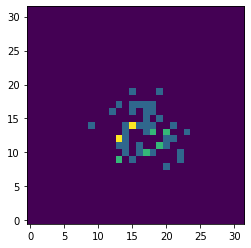

In [8]:
mock_image = np.loadtxt('toy_photometry.dat')
class Image:
    def __init__(self, image):
        self.im = image
        self.imx,self.imy = np.meshgrid(range(image.shape[1]), range(image.shape[0]))
        # this part is new and will be motivated below
        self.N = int(image.sum())
        j = np.where(image.flatten() > 0)[0]
        xs = []
        ys = []
        for jj in j:
            xs += [self.imx.flatten()[jj]] * int(image.flatten()[jj])
            ys += [self.imy.flatten()[jj]] * int(image.flatten()[jj])
        self.x = np.array(xs)
        self.y = np.array(ys)
data = Image(mock_image)
plt.imshow(data.im, origin='lower');

We'll still want to refer to the truth model used to generate the above data:

In [9]:
paramnames = ['x0', 'y0', 'mu0', 'sigma'] # the canonical parameter order, because I said so
truth = {'x0':17.1, 'y0':12.75, 'mu0':50.0, 'sigma':3.0}

## Fitting for 2 parameters

We'll see below that the conjugate Gibbs approach works well for the full 4-parameter problem. To begin with, however, we'll use the simplified 2-parameter model (with the source position fixed) to introduce the method.

### The likelihood

Time for some math. (Recall that conjuate Gibbs sampling sometimes lets us design a very efficient sampler at the cost of doing some math ourselves.)

Our likelihood in this problem was Poisson, with the mean parameter in each pixel being given by the average number of photons expected from the source in our observation ($\mu_0$), the width of a symmetric Gaussian PSF ($\sigma$), the source position $(x_0,y_0)$, and the position of the pixel in question $(x,y)$.

We previously implicitly alluded to the fact that this likelihood can be factorized into the probability of detecting $N$ photons in total within the image, and the probability of a particular spatial distribution of those photons. Let's formalize this, since it will be helpful in a minute.

Namely, if $N_i$ is the number of photons measured in pixel $i$, with $N=\sum_i N_i$, then

$p(\{N_i\}|\mu_0,\sigma) = \mathrm{Poisson}(N|\mu_0) \prod_{j=1}^N \mathrm{PSF}(x_j-x_0,y_j-y_0)$.

Here the index $j$ runs over pixels where photons were detected, multiply counting those pixels where there are multiple photons.

Since we need to do math with this, let's explicitly plug in the form of the PSF. Note that (as we discussed in the previous tutorial), we are going to be naughty and pretend that the PSF evaluated at the center of a pixel is the same as its value integrated over the pixel. This means that the equality is not a proportionality (the sampling distribution is no longer normalized), but that detail won't impact us in the end.

$p(\{N_i\}|\mu_0,\sigma) \propto \mathrm{Poisson}(N|\mu_0) \prod_{j=1}^N \mathrm{Normal}(x_j|x_0,\sigma) \, \mathrm{Normal}(y_j|y_0,\sigma)$.

Finally, we can shorten this even more by concatenating $\mathbf{x}-x_0$ and $\mathbf{y}-y_0$ into $\mathbf{z}$, indexed by $k$, writing

$p(\{N_i\}|\mu_0,\sigma) \propto \mathrm{Poisson}(N|\mu_0) \prod_{k=1}^{2N} \mathrm{Normal}(z_k|0,\sigma)$.

This last step is just a notation trick to emphasize that all the displacements in both $x$ and $y$ from $(x_0,y_0)$ tell us about the PSF width, $\sigma$. This product indexed by $k$ thus has twice the number factors as the product over $j$ above.

For convenience, the improved `Image` class defined above provides direct access to $N$ and arrays of photon $x$ and $y$ positions. As in:

In [10]:
print(data.N)
print(data.x)
print(data.y)

52
[20 13 13 15 22 14 16 17 17 18 22 13 14 16 19 19 20 13 13 13 14 20 21 14
 17 18 18 20 20 23  9 14 15 15 15 16 17 18 21 17 19 12 15 17 18 13 15 16
 17 18 15 19]
[ 8  9  9  9  9 10 10 10 10 10 10 11 11 11 11 11 11 12 12 12 12 12 12 13
 13 13 13 13 13 13 14 14 14 14 14 14 14 14 14 15 15 16 16 16 16 17 17 17
 17 17 19 19]


### Conjugacy

The form of the likelihood is now about as simple as we could hope for. Next, we need to work out the conjugate relations for updating each parameter, and decide whether we can live with the form of the prior that this would require.

#### Relation for $\mu_0$

The dependence of the likelihood on $\mu_0$ is all in a Poisson term, and we see from [the repository of all knowledge](https://en.wikipedia.org/wiki/Conjugate_prior) that the conjugate prior is the Gamma distribution. Since this conjugacy was worked out [in the notes](../notes/bayes_law.ipynb), we won't make you derive it here. Lucky you!

Recall that, for conjugate Gibbs sampling, we need to find the posterior for $\mu_0$ _conditioned on all other parameters_. This is why we can afford to only pay attention to terms in the posterior that contain $\mu_0$ - any term that doesn't must come out in the wash when the conditional posterior is normalized. Much simpler than dealing with marginalization or some other operation! So, using the Poisson-Gamma conjugacy relation, we have that

$\mathrm{Gamma}(\mu_0|\alpha_0,\beta_0) \, \mathrm{Poisson}(N|\mu_0,\ldots) \propto \mathrm{Gamma}(\mu_0|\alpha_0+N,\beta_0+1) = p(\mu_0|\{N_i\};\ldots)$,

where "$\ldots$" stands for all the other parameters: $x_0,y_0,\sigma$.

Again, remember that the posterior _must be_ a normalized PDF. Hence, the RHS of the proportionality _is_ the posterior for $\mu_0$. If we had carefully kept track of all the normalizing factors and computed the evidence, this is what it would work out to be. Aren't we lucky that we didn't need to do so explicitly?

So we _could_ use conjugate Gibbs sampling for $\mu_0$, but should we? In other words, can we find a prior we can live with within the [Gamma](https://en.wikipedia.org/wiki/Gamma_distribution) family? Yes, in this case. Here are some special cases of the distribution, some of which you can verify by inspection of its PDF:
* $(\alpha_0=1,\beta_0\rightarrow0)$ is uniform on $\mu_0>0$;
* $(\alpha_0\rightarrow0,\beta_0\rightarrow0)$ is $p(\mu_0)\propto 1/\mu_0$, or uniform in $\ln(\mu_0)$;
* $(\alpha_0=1/2,\beta_0\rightarrow0)$ turns out to be the Jefferys prior, $p(\mu_0) \propto \mu_0^{-1/2}$, that we used previously. Let's do so again.

#### Relation for $\sigma$

Specifically, we are looking for a conjugate relation for the standard deviation of a Normal likelihood, with a known mean, since we are conditioning on $x_0$ and $y_0$. This conjugacy relation is much more annoying to work out, but the Wikipedia tells us what the update rule for the **variance** (not the standard deviation, but $\sigma^2$) is, and that the conjugate prior is the "scaled inverse chi-square" distribution:

$\mathrm{SclInv}\chi^2(\sigma^2|\nu_0,\sigma_0^2) \, \prod_{k=1}^{2N}\mathrm{Normal}(z_k|0,\sigma,\ldots) \propto \mathrm{SclInv}\chi^2\left(\sigma^2\left|\nu_0+2N, \frac{\nu_0\sigma_0^2 + \sum_{k=1}^{2N} z_k^2}{\nu_0+2N}\right.\right) = p(\sigma^2|\{N_i\};\ldots)$.

Again, the $2N$s here come about because, for each of the $N$ detected photons, both their $x$ and $y$ displacements from the source position tell us something about $\sigma$.

The [scaled inverse $\chi^2$ distribution](https://en.wikipedia.org/wiki/Scaled_inverse_chi-squared_distribution) is a little uglier than we're used to, but not all that hard to deal with due to it's close relationship with the $\chi^2$ distribution. Again we can find values or limits of the parameters that are compatible with some of the "uninformative" choices we might want to make. See if these make sense by inspection of the PDF (all these have non-positive-integer degrees of freedom, which is admittedly bizarre, but the math works out):
* $(\nu_0=-2,\sigma_0^2\rightarrow0)$ is uniform in $\sigma^2$;
* $(\nu_0=-1,\sigma_0^2\rightarrow0)$ is uniform in $\sigma$, $p(\sigma^2) \propto \sigma^{-1}$;
* $\nu_0\rightarrow0$ and any $\sigma_0^2$ is $p(\sigma^2) \propto \sigma^{-2}$.

One of these is equivalent to the prior we used before, $p(\sigma)\propto \sigma^{-1}$, but it may not be the one you think! Remember that we've made a non-linear change of variables here ($\sigma$ to $\sigma^2$) and that in general the prior density is not invariant under such a transformation. Use what you learned way back in [Probability Tranformations](../notes/probability_transformations.ipynb) to work out the prior we want on $\sigma^2$, and hence which of the hyperparameter choices above we should use.

$p(\sigma^2)\sim p(\sigma)\big(\frac{\partial\sigma}{\partial\sigma^2}\big)^{-1}\sim \sigma^{-1}\sigma^{-1}=\sigma^{-2}$

### Implementation

So, now we have rules from drawing samples from the posterior distributions of both parameters. In fact, we even have the posterior distribution in closed form, since in this case it factored cleanly into $p(\mu_0,\sigma|\{N_i\})=p(\mu_0|\{N_i\})p(\sigma|\{N_i\})$. That is, we won't actually need to generate a Markov chain, we can sample directly from the posterior without correlation between samples! This is called "independence sampling".

Later, we'll see that this is no longer the case when we introduce the source $x$ and $y$ positions as free parameters; then we will need to sample from the _fully conditional_ posterior of each parameter in turn, producing a Markov chain of samples that approximate draws from the full posterior.

But, before tackling that, let's get some code together to produce samples from the simpler case we're starting with, with just the two free parameters. Note that sampling from the scaled inverse $\chi^2$ distribution is slightly involved, but not too complicated; it just follows from the definition of the distribution, so you ultimately end up drawing from a $\chi^2$ distribution and applying some transformations to those random draws.

The cell below just defines dictionaries for the model parameters and prior hyperparameters as usual. Fill in the correct hyperparameters for the $\sigma^2$ prior based on your answer above. Note that, because we can do independence sampling here, we don't actually need starting guesses for $\mu_0$ and $\sigma$!

In [11]:
params = {'mu0':None, 'sigma':None, 'x0':truth['x0'], 'y0':truth['y0']}
hyperparams = {'alpha0':0.5, 'beta0':0.0, 'nu0':0.0, 'sigmasq0':1.0}

Now for the fun part: write a function that takes the data, model parameters and prior hyperparameters as input, and returns a new sample of $\mu$ and $\sigma$ based on the posteriors above. Note that **you should return $\sigma$, not $\sigma^2$**. (There is nothing to this other than taking a square root - post-facto transformations of parameters is simple; the only wrinkle is in chosing the appropriate prior density as we did above.)

Even though we chose specific hyperparameter values above, you should write your code such that any valid values can be passed.

Note that the `scipy` implementation of the gamma distribution doesn't have $\alpha$ and $\beta$ as parameters; instead one needs to pass arguments `a=alpha` and `scale=1/beta` (for reasons).

$\mathrm{Gamma}(\mu_0|\alpha_0,\beta_0) \, \mathrm{Poisson}(N|\mu_0,\ldots) \propto \mathrm{Gamma}(\mu_0|\alpha_0+N,\beta_0+1) = p(\mu_0|\{N_i\};\ldots)$,
$\mathrm{SclInv}\chi^2(\sigma^2|\nu_0,\sigma_0^2) \, \prod_{k=1}^{2N}\mathrm{Normal}(z_k|0,\sigma,\ldots) \propto \mathrm{SclInv}\chi^2\left(\sigma^2\left|\nu_0+2N, \frac{\nu_0\sigma_0^2 + \sum_{k=1}^{2N} z_k^2}{\nu_0+2N}\right.\right) = p(\sigma^2|\{N_i\};\ldots)$.

In [24]:
import scipy.stats as st
def independence_sampler(img, par, hypar):
    """
    img is of type Image
    par and hypar are our params and hyperparams dictionaries
    """
    # You will need to do some calculations involving the image data (img.N, img.x, img.y)...
    # Some of these could be done once instead of repeating every time this function is called, if the
    # x0 and y0 parameters are fixed, but let's not build that assumption in.
    N,xs,ys=img.N,img.x-par['x0'],img.y-par['y0']
    # and then work out parameters of the conditional posterior for mu0, and draw a sample from it...
    mu0=st.gamma.rvs(a=hypar['alpha0']+N,scale=1/(hypar['beta0']+1),size=1)
    # and then do the same for sigma^2...
    zsum=np.sum(xs**2)+np.sum(ys**2)
    tausq=(hypar['nu0']*hypar['sigmasq0']+zsum)/(hypar['nu0']+2*N)
    nu=hypar['nu0']+2*N
    invchi2=1/st.chi2.rvs(nu,size=1)
    ScInvChi2=nu*tausq*invchi2
    sigma=np.sqrt(ScInvChi2)
    # and then return the new samples as a tuple, (mu0, sigma)
    return (mu0,sigma)

Let's see what a few samples generated by this function look like.

In [25]:
np.array([independence_sampler(data, params, hyperparams) for i in range(10)])

array([[[61.57840679],
        [ 2.70652558]],

       [[62.69977442],
        [ 3.00241293]],

       [[40.59500974],
        [ 2.94282779]],

       [[48.95138815],
        [ 2.6753977 ]],

       [[50.41156219],
        [ 2.46251998]],

       [[42.80199648],
        [ 2.58470296]],

       [[49.34767452],
        [ 2.97713949]],

       [[45.44438898],
        [ 2.73655736]],

       [[56.13773308],
        [ 2.84714341]],

       [[47.36761164],
        [ 2.81104141]]])

### Results

We could generate lots of samples with a python construction like the one above (because, again, this case is independence sampling). But, instead, let's belabor it as though we actually had to create a Markov chain, where each sample is dependent on the previous one. The cell below does this, updating the `params` dictionary within a loop (compare with the pseudocode in the [notes](../notes/montecarlo.ipynb)), and collecting all the samples in an array.

In [26]:
%%time
nsamples = 10000
samples2 = np.zeros((nsamples, 2))
for i in range(samples2.shape[0]):
    p = independence_sampler(data, params, hyperparams)
    params['mu0'] = p[0]
    params['sigma'] = p[1]
    samples2[i,:] = p

<timed exec>:7: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.


CPU times: user 3.51 s, sys: 94.9 ms, total: 3.61 s
Wall time: 7.31 s


We can use `plotGTC` to quickly visualize the posterior. This package shows us all the 1D marginalized posteriors and every pair of 2D marginalized posteriors (as a contour plot), after some smoothing, in a triangular grid. Dashed lines show the truth values the data were simulated from.

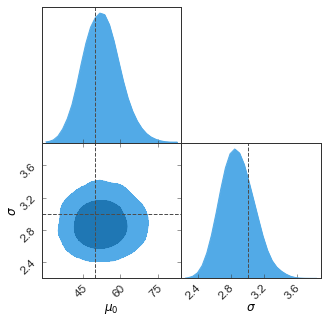

In [27]:
plotGTC(samples2, paramNames=[r'$\mu_0$', r'$\sigma$'], truths=[truth['mu0'], truth['sigma']],
        figureSize=5, customLabelFont={'size':12}, customTickFont={'size':12});

**Checkpoint:** The cell below will compare your samples with some we have generated. They won't be identical, but should be extremely close if you've used the priors and data specified above.

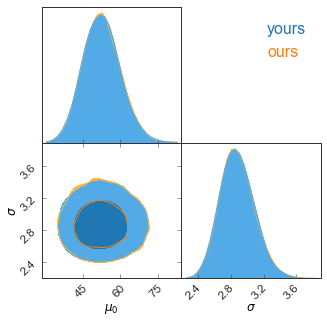

In [28]:
ours = np.loadtxt('gibbs.dat.gz')
plotGTC([samples2, ours], paramNames=[r'$\mu_0$', r'$\sigma$'], chainLabels=['yours', 'ours'],
        figureSize=5, customLabelFont={'size':12}, customTickFont={'size':12}, customLegendFont={'size':16});

In order to compare to the corresponding grid analysis, let's compute credible intervals with the same code:

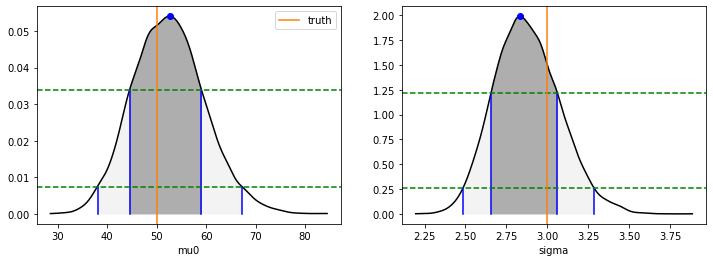

In [29]:
plt.rcParams['figure.figsize'] = (12.0, 4.0)
fig, ax = plt.subplots(1,2)
marg1d = [cr.whist(samples2[:,i]) for i in range(samples2.shape[1])]
ci1d = [cr.whist_ci(marg, plot=axes) for marg,axes in zip(marg1d,ax)]
for i in range(2):
    ax[i].set_xlabel(paramnames[i+2])
    ax[i].axvline(truth[paramnames[i+2]], color='C1', label='truth')
ax[0].legend();

In [30]:
ci1d

[{'mode': 52.56105317823754,
  'level': array([0.68268949, 0.95449974]),
  'prob': array([0.68366027, 0.95475824]),
  'density': array([0.03382788, 0.00729426]),
  'min': array([44.56779095, 37.99798638]),
  'max': array([59.02136101, 67.23361672]),
  'low': array([ -7.99326223, -14.5630668 ]),
  'high': array([ 6.46030783, 14.67256354]),
  'center': array([51.79457598, 52.61580155]),
  'width': array([ 7.22678503, 14.61781517])},
 {'mode': 2.8307873638418526,
  'level': array([0.68268949, 0.95449974]),
  'prob': array([0.68295175, 0.95520124]),
  'density': array([1.21641478, 0.25630903]),
  'min': array([2.65880578, 2.48682419]),
  'max': array([3.0589937, 3.2838927]),
  'low': array([-0.17198159, -0.34396317]),
  'high': array([0.22820634, 0.45310533]),
  'center': array([2.85889974, 2.88535844]),
  'width': array([0.20009396, 0.39853425])}]

Compare the `center` and `width` summaries of each parameter with what you got from the grid analysis. Do you have the same results to the precision that one would normally report?

Pretty good.

## Fitting for 4 parameters

Let's now fit for the source position also ($x_0$ and $y_0$).

### Doing the math

Let's explicitly write down the fully conditional posteriors for the case where the source position is free.

Nothing has changed for the total mean number of counts, which remains indepedent of the other parameters:

$p(\mu|\{N_i\};\ldots) = \mathrm{Gamma}(\mu|\alpha_0+N,\beta_0+1)$.


The fully conditional posterior for $\sigma^2$ is just as it was before, but we should explicitly admit that we are conditioning on $x_0$ and $y_0$, and show where they enter the expression. Make sure you're happy with this, comparing with our previous equations, before going on.

$p(\sigma^2|\{N_i\};x_0, y_0,\ldots) = \mathrm{SclInv}\chi^2\left(\sigma^2\left|\nu_0+n_k, \frac{1}{\nu_0+2N}\left[\nu_0\sigma_0^2 + \sum_{j=1}^N (x_0-x_j)^2 + \sum_{j=1}^N (y_0-y_j)^2 \right]\right.\right)$.

Finally, we need the fully conditional posteriors for $x_0$ and $y_0$. Each of these parameters is, independently, the mean of a normal distribution with standard deviation $\sigma$ in our model. Looking it up, we see that the conjugate prior is also normal. This is a little bit fiddly to show, but relatively straightforward using the Gaussian identities you've worked with [previously](gaussians.ipynb). Whether or not you take the time to work this out yourself, it's worth checking that the way the information from the prior and data are combined in the expressions below makes sense.

Denoting the hyperparameters of the conjugate priors $(m_x,s_x,m_y,s_y)$, we have

$p(x_0|\sigma, \{N_i\}) = \mathrm{Normal}\left(x_0\left|\left[\frac{1}{s_x^2}+\frac{N}{\sigma^2}\right]^{-1}\left[\frac{m_x}{s_x^2}+\frac{\sum_j x_j}{\sigma^2}\right], \left[\frac{1}{s_x^2}+\frac{N}{\sigma^2}\right]^{-1/2}\right.\right)$,

$p(y_0|\sigma, \{N_i\}) = \mathrm{Normal}\left(y_0\left|\left[\frac{1}{s_y^2}+\frac{N}{\sigma^2}\right]^{-1}\left[\frac{m_y}{s_y^2}+\frac{\sum_j y_j}{\sigma^2}\right], \left[\frac{1}{s_y^2}+\frac{N}{\sigma^2}\right]^{-1/2}\right.\right)$.

In the grid solution, we used uniform priors for $x_0$ and $y_0$ _confined to the image_. This is not something that a Gaussian distribution can reproduce. On the other hand, we know from that analysis (and could reasonably suspect in this case) that $x_0$ and $y_0$ will be constrained well enough that they will not be consistent with the image edges, in which case the functional difference between a uniform prior over the image and an improper uniform prior over the whole $x_0$-$y_0$ plane is minimal. Let's therefore adopt the improper uniform prior, which corresponds to the limit $s_x,s_y\rightarrow\infty$ (at which point the values of $m_x$ and $m_y$ cease to be important). However, as before, you should write your code such that any valid hyperparameters can be used. Here we add them to the `hyperparameters` dictionary:

In [31]:
hyperparams['mx'] = 0.0
hyperparams['sx'] = np.inf
hyperparams['my'] = 0.0
hyperparams['sy'] = np.inf

### Implementation

Remember that we can no longer use independence sampling. Now each parameter must be updated in turn, meaning the new value of one parameter is used when updating the next parameter, and so on. So, let's explicitly write separate functions for updating different sets of parameters. The first two can, naturally, re-use code you've written above.

$p(\mu|\{N_i\};\ldots) = \mathrm{Gamma}(\mu|\alpha_0+N,\beta_0+1)$.

In [34]:
def update_mu0(img, par, hypar):
    N,xs,ys=img.N,img.x-par['x0'],img.y-par['y0']
    par['mu0']=st.gamma.rvs(a=hypar['alpha0']+N,scale=1/(hypar['beta0']+1),size=1)

$p(\sigma^2|\{N_i\};x_0, y_0,\ldots) = \mathrm{SclInv}\chi^2\left(\sigma^2\left|\nu_0+2N, \frac{1}{\nu_0+2N}\left[\nu_0\sigma_0^2 + \sum_{j=1}^N (x_0-x_j)^2 + \sum_{j=1}^N (y_0-y_j)^2 \right]\right.\right)$.

In [35]:
def update_sigma(img, par, hypar):
    N,xs,ys=img.N,img.x-par['x0'],img.y-par['y0']
    zsum=np.sum(xs**2)+np.sum(ys**2)
    tausq=(hypar['nu0']*hypar['sigmasq0']+zsum)/(hypar['nu0']+2*N)
    nu=hypar['nu0']+2*N
    invchi2=1/st.chi2.rvs(nu,size=1)
    ScInvChi2=nu*tausq*invchi2
    par['sigma']=np.sqrt(ScInvChi2)

The updates for $x_0$ and $y_0$ will naturally be very similar, but let's keep them in different functions anyway.

$p(x_0|\sigma, \{N_i\}) = \mathrm{Normal}\left(x_0\left|\left[\frac{1}{s_x^2}+\frac{N}{\sigma^2}\right]^{-1}\left[\frac{m_x}{s_x^2}+\frac{\sum_j x_j}{\sigma^2}\right], \left[\frac{1}{s_x^2}+\frac{N}{\sigma^2}\right]^{-1/2}\right.\right)$,

$p(y_0|\sigma, \{N_i\}) = \mathrm{Normal}\left(y_0\left|\left[\frac{1}{s_y^2}+\frac{N}{\sigma^2}\right]^{-1}\left[\frac{m_y}{s_y^2}+\frac{\sum_j y_j}{\sigma^2}\right], \left[\frac{1}{s_y^2}+\frac{N}{\sigma^2}\right]^{-1/2}\right.\right)$.

In [38]:
def update_x0(img, par, hypar):
    N,xs=img.N,img.x
    mx,sx,my,sy=hypar['mx'],hypar['sx'],hypar['my'],hypar['sy']
    sumx=np.sum(xs)
    lo=1/(1/sx**2+N/par['sigma']**2)*(mx/sx**2+sumx/par['sigma']**2)
    sc=1/np.sqrt(1/sx**2+N/par['sigma']**2)
    par['x0']=st.norm.rvs(loc=lo,scale=sc,size=1)
def update_y0(img, par, hypar):
    N,ys=img.N,img.y
    mx,sx,my,sy=hypar['mx'],hypar['sx'],hypar['my'],hypar['sy']
    sumy=np.sum(ys)
    lo=1/(1/sy**2+N/par['sigma']**2)*(my/sy**2+sumy/par['sigma']**2)
    sc=1/np.sqrt(1/sx**2+N/par['sigma']**2)
    par['y0']=st.norm.rvs(loc=lo,scale=sc,size=1)

Let's test all of that by calling each function and verifying that all the parameters changed (to finite, allowed values).

In [39]:
print('Before:', params)
params2 = params.copy()
update_mu0(data, params2, hyperparams)
update_sigma(data, params2, hyperparams)
update_x0(data, params2, hyperparams)
update_y0(data, params2, hyperparams)
print('After:', params2)

Before: {'mu0': array([43.41008898]), 'sigma': array([2.84871938]), 'x0': 17.1, 'y0': 12.75}
After: {'mu0': array([40.63651274]), 'sigma': array([2.93494746]), 'x0': array([16.68300427]), 'y0': array([13.34015739])}


### Results

As before, we can fill in an array with samples generated with the functions above. Note that, this time, the for loop is necessary, since we can't fill in row $i$ without knowing the contents of row $(i-1)$. The order of the individual parameter updates is arbitrary, and could even be randomized if you particularly wanted to.

In [40]:
%%time
samples4 = np.zeros((nsamples,4))
for i in range(samples4.shape[0]):
    update_mu0(data, params, hyperparams)
    update_sigma(data, params, hyperparams)
    update_x0(data, params, hyperparams)
    update_y0(data, params, hyperparams)
    samples4[i,:] = [params[k] for k in paramnames]

<timed exec>:7: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.


CPU times: user 5.37 s, sys: 101 ms, total: 5.47 s
Wall time: 5.94 s


Let's do the most basic (yet still extremely important) visual check to see how our sampler performed, looking at traces of the Markov chain for each parameter. (It's ok if you haven't read the notes on [MCMC Diagnostics](../notes/mcmc_diagnostics.ipynb) yet; we will go more in-depth later.) These trace plots show the value of each parameter as a function of iteration, and we'll add a line showing the value that was used to create the mock data.

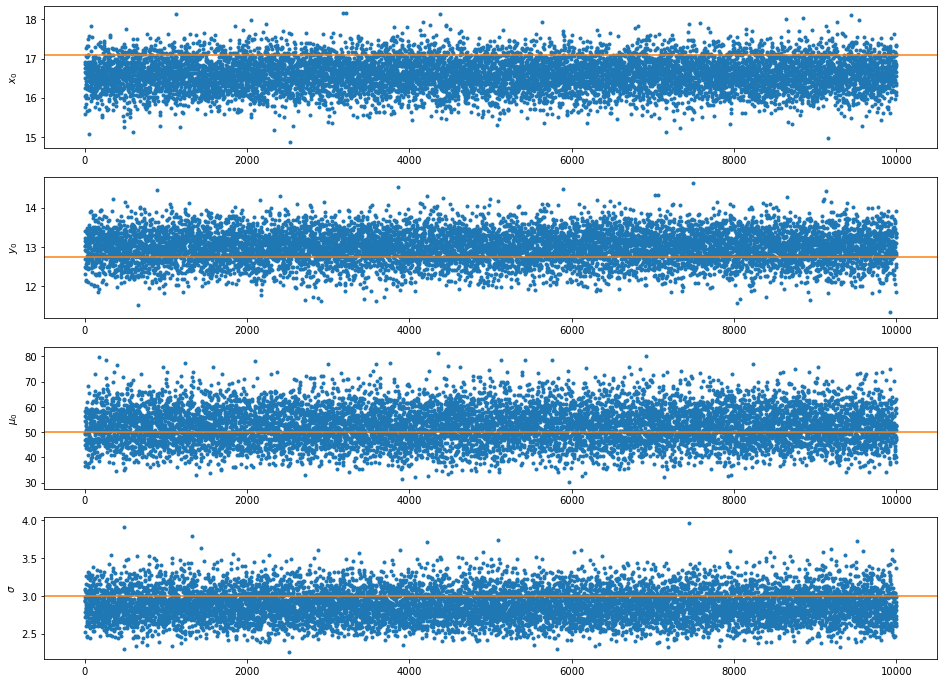

In [41]:
param_labels = [r'$x_0$', r'$y_0$', r'$\mu_0$', r'$\sigma$']
plt.rcParams['figure.figsize'] = (16.0, 12.0)
fig, ax = plt.subplots(4,1);
cr.plot_traces(samples4, ax, labels=param_labels, 
            truths=[truth[k] for k in paramnames])

Note that if you started with pretty reasonable parameter values, which is likely if you've been following the notebook top to bottom, it's entirely possible that there isn't a clear burn-in phase that needs to be thrown out.

We can look at the triangle-plot summary of the posterior as before:

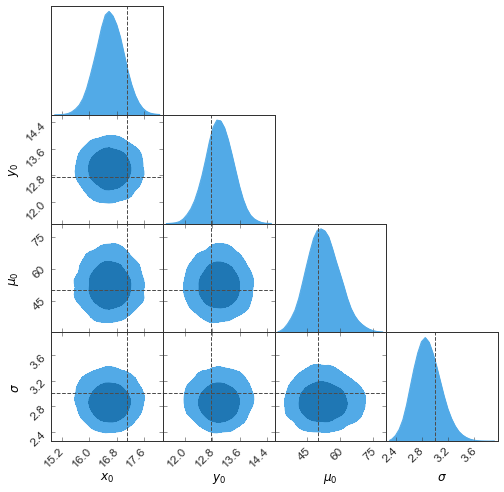

In [42]:
plotGTC(samples4, paramNames=param_labels,
        truths=[truth[k] for k in paramnames],
        figureSize=8, customLabelFont={'size':12}, customTickFont={'size':12});

**Checkpoint:** Once again, you can compare these to our own solutions; the posteriors should look very similar.

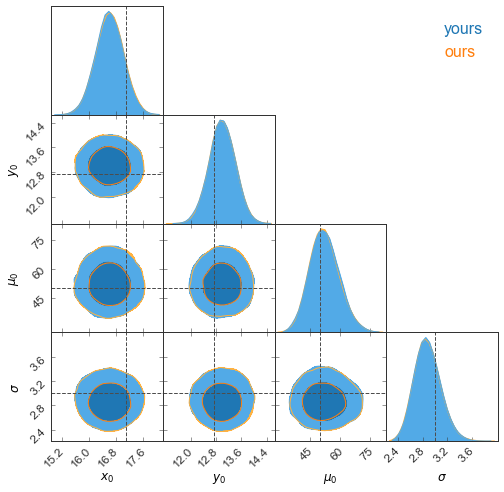

In [44]:
ours = np.loadtxt('gibbs4.dat.gz')
plotGTC([samples4, ours], paramNames=param_labels,
        truths=[truth[k] for k in paramnames], chainLabels=['yours', 'ours'], customLegendFont={'size':16},
        figureSize=8, customLabelFont={'size':12}, customTickFont={'size':12});

Let's find the credible intervals, for completeness. We won't bother with the goodness of fit, since the grid analysis did address that.

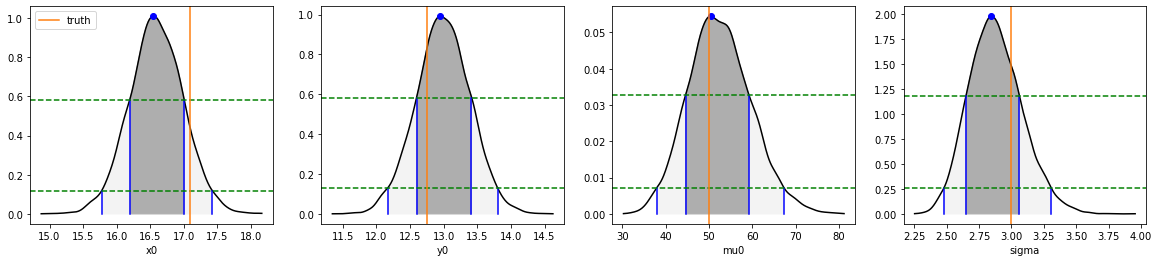

In [45]:
plt.rcParams['figure.figsize'] = (20.0, 4.0)
fig, ax = plt.subplots(1,len(paramnames))
marg1d = [cr.whist(samples4[:,i]) for i in range(samples4.shape[1])]
ci1d = [cr.whist_ci(marg, plot=axes) for marg,axes in zip(marg1d,ax)]
for i in range(len(paramnames)):
    ax[i].set_xlabel(paramnames[i])
    ax[i].axvline(truth[paramnames[i]], color='C1', label='truth')
ax[0].legend();

Any qualitative observations on how the marginalized posteriors compare to their counterparts from the course grid analysis?

In [ ]:
TBC() # answer in Markdown

In [ ]:
ci1d # for posterity

We weren't overly concerned with the starting point for the test chain above. But, for later notebooks, we'll want to see how multiple, independent chains with different starting points behave when using this method. The cell below will take care of running 4 chains, started at random yet broadly reasonable positions.

In [ ]:
%%time
chains = [np.zeros((10000,4)) for j in range(4)]

for samples in chains:
    params = {'mu0':st.uniform.rvs()*100.0,
              'sigma':st.uniform.rvs()*9.9 + 0.1,
              'x0':st.uniform.rvs()*32.0,
              'y0':st.uniform.rvs()*32.0}
    for i in range(samples.shape[0]):
        update_mu0(data, params, hyperparams)
        update_sigma(data, params, hyperparams)
        update_x0(data, params, hyperparams)
        update_y0(data, params, hyperparams)
        samples[i,:] = [params[k] for k in paramnames]

Now we can look at a more colorful version of the trace plots, showing all of the chains simultaneously:

In [ ]:
plt.rcParams['figure.figsize'] = (16.0, 12.0)
fig, ax = plt.subplots(len(param_labels), 1);
cr.plot_traces(chains, ax, labels=param_labels, Line2D_kwargs={'markersize':1.0},
           truths=[truth[k] for k in paramnames], truth_kwargs={'color':'k', 'linestyle':'--'})

Here you might be able to see some extreme values as the chains burn in, before they settle down to sampling the posterior distribution.

Save them for later, and we're done!

In [ ]:
for i,samples in enumerate(chains):
    np.savetxt('saved/toy_gibbs_chain_'+str(i)+'.txt.gz', samples, header=' '.join(paramnames))

## Parting thoughts

There you have it - at the cost of engaging our brains, you have now fit a model with enough free parameters to make a grid-based solution uncomfortably slow. Conjugate Gibbs sampling is often, though not always, highly efficient when it's applicable. Problems that are fully conjugate are not all that common, although, as you'll see later on, it's sometimes possible to perform conjugate updates of a subset of parameters in a complex model, using other strategies for the remaining parameters.

## Bonus

If you have already done the [Metropolis Sampling](toy_photometry_metro.ipynb) tutorial, comment on the differences you see between the chains that the two methods produce.

In [ ]:
# answer in Markdown